# Actividad: Bagging vs. Random Forest con Datos Balanceados

### Introducción Teórica
El método de Random Forest se fundamenta como una mejora sobre Bagging, principalmente por su capacidad para reducir la correlación entre los árboles individuales que componen el ensamblaje. Esto se logra mediante la introducción de un subconjunto aleatorio de predictores en cada división del árbol. 

Dado que en esta actividad utilizaremos un **dataset perfectamente balanceado (50/50)**, podremos comparar ambos algoritmos en un escenario ideal, enfocándonos únicamente en el impacto de su mecánica interna sin la variable confusora del desbalance de clases.

### Objetivo de la Actividad
Evaluar y comparar el rendimiento predictivo y la interpretación de los resultados de un modelo de Bagging frente a un modelo de Random Forest en un problema de clasificación con datos balanceados.


## 1. Preparación del Entorno y Carga de Datos
Importaremos las librerías necesarias y cargaremos nuestro nuevo dataset balanceado, `prediccion_pobreza_peru_balanceada.csv`, antes de dividirlo para el entrenamiento y la prueba.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# Configuraciones
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Carga y preparación de datos
# ¡IMPORTANTE! Usamos el nuevo archivo balanceado.
df = pd.read_csv('pobreza_super_predictores.csv')
X = df.drop('PobrezaMonetaria', axis=1)
y = df['PobrezaMonetaria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("✅ Entorno y datos preparados.")
print("\nVerificación de la distribución en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))


✅ Entorno y datos preparados.

Verificación de la distribución en el conjunto de entrenamiento:
PobrezaMonetaria
0    0.5
1    0.5
Name: proportion, dtype: float64


## 2. Implementación del Modelo 1: Bagging Classifier
Nuestro primer modelo será un ensamblaje de Bagging. Note que, como nuestros datos están balanceados, **no necesitamos usar el parámetro `class_weight`**. El estimador base será un `DecisionTreeClassifier` estándar.

In [2]:
# Preprocesador (común para ambos modelos)
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Creación del pipeline para Bagging
# NOTA: En versiones recientes de scikit-learn, el parámetro es 'estimator', no 'base_estimator'.
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42), # No se necesita class_weight
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento del modelo
print("🚀 Entrenando el modelo Bagging...")
bagging_pipeline.fit(X_train, y_train)
print("✅ Modelo Bagging entrenado.")

# Evaluación
print("\n--- Evaluación del Modelo Bagging ---")
y_pred_bagging = bagging_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_bagging, target_names=['No Pobre (0)', 'Pobre (1)']))


🚀 Entrenando el modelo Bagging...
✅ Modelo Bagging entrenado.

--- Evaluación del Modelo Bagging ---
              precision    recall  f1-score   support

No Pobre (0)       0.85      0.89      0.87       450
   Pobre (1)       0.89      0.84      0.86       450

    accuracy                           0.87       900
   macro avg       0.87      0.87      0.87       900
weighted avg       0.87      0.87      0.87       900



## 3. Implementación del Modelo 2: Random Forest
Ahora, construiremos el modelo de Random Forest. La única diferencia con Bagging es que el algoritmo interno de Random Forest aplicará la selección aleatoria de características en cada división del árbol.

In [3]:
# Creación del pipeline para Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, # Mismo número de árboles para una comparación justa
        random_state=42,  # No se necesita class_weight
        n_jobs=-1
    ))
])

# Entrenamiento del modelo
print("🚀 Entrenando el modelo Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("✅ Modelo Random Forest entrenado.")

# Evaluación
print("\n--- Evaluación del Modelo Random Forest ---")
y_pred_rf = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['No Pobre (0)', 'Pobre (1)']))


🚀 Entrenando el modelo Random Forest...
✅ Modelo Random Forest entrenado.

--- Evaluación del Modelo Random Forest ---
              precision    recall  f1-score   support

No Pobre (0)       0.86      0.87      0.86       450
   Pobre (1)       0.87      0.86      0.86       450

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900



## 4. Análisis Comparativo de Resultados
Con ambos modelos entrenados, ahora podemos comparar su rendimiento de manera directa.

### 4.1 Comparación de Métricas de Rendimiento
Dado que las clases están balanceadas, ahora la métrica de **`accuracy`** es un indicador fiable, junto con el **`AUC`**.

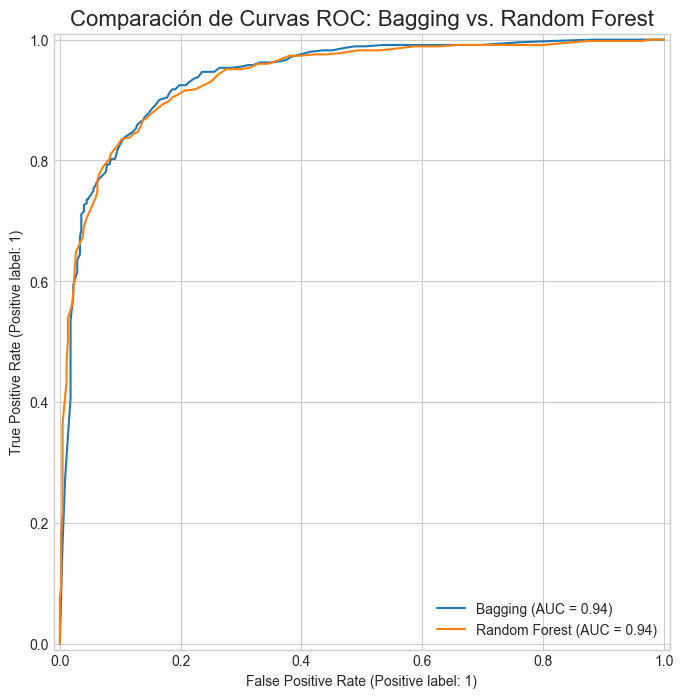

AUC del Modelo Bagging: 0.9396
AUC del Modelo Random Forest: 0.9378


In [4]:
# Comparación de Curvas ROC
fig, ax = plt.subplots(figsize=(10, 8))
RocCurveDisplay.from_estimator(bagging_pipeline, X_test, y_test, ax=ax, name='Bagging')
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test, ax=ax, name='Random Forest')
ax.set_title('Comparación de Curvas ROC: Bagging vs. Random Forest', fontsize=16)
plt.show()

# Comparación numérica
auc_bagging = roc_auc_score(y_test, bagging_pipeline.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
print(f"AUC del Modelo Bagging: {auc_bagging:.4f}")
print(f"AUC del Modelo Random Forest: {auc_rf:.4f}")


### 4.2 Comparación de Importancia de Variables
¿Coinciden ambos modelos en cuáles son las variables más predictivas?

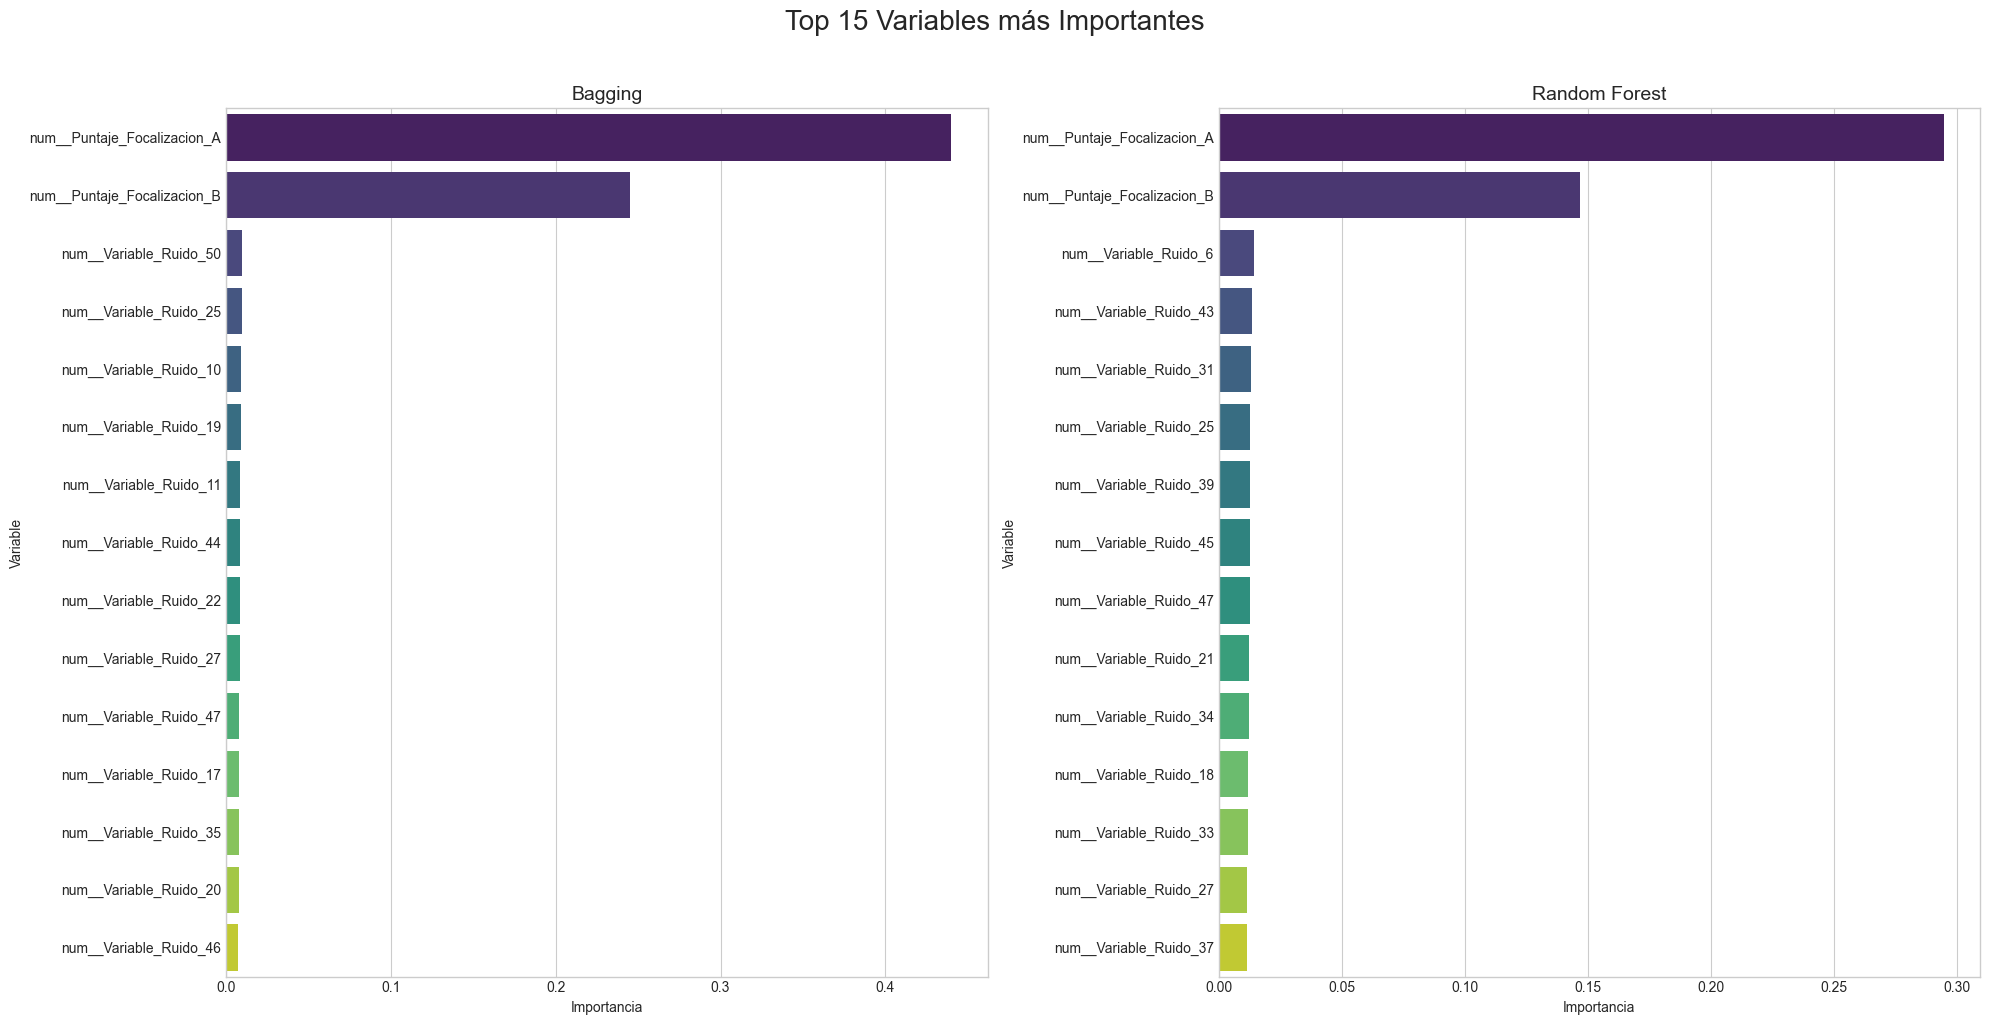

In [5]:
# Función para obtener y graficar la importancia de variables
def plot_feature_importance(pipeline, title, ax):
    feature_names_raw = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    if isinstance(pipeline.named_steps['classifier'], RandomForestClassifier):
        importances = pipeline.named_steps['classifier'].feature_importances_
    elif isinstance(pipeline.named_steps['classifier'], BaggingClassifier):
        importances = np.mean([tree.feature_importances_ for tree in pipeline.named_steps['classifier'].estimators_], axis=0)
    
    df_importance = pd.DataFrame({'feature': feature_names_raw, 'importance': importances}).sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=df_importance.head(15), ax=ax, palette='viridis')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Importancia')
    ax.set_ylabel('Variable')

# Crear subplots para comparar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.suptitle('Top 15 Variables más Importantes', fontsize=20, y=1.02)
plot_feature_importance(bagging_pipeline, 'Bagging', ax=ax1)
plot_feature_importance(rf_pipeline, 'Random Forest', ax=ax2)
plt.tight_layout()
plt.show()


## 5. Análisis de Resultados y Discusión
Una vez implementados ambos modelos y visualizados los resultados, proceda a realizar un análisis comparativo respondiendo a las siguientes cuestiones.

### Cuestión 1: Rendimiento Predictivo
Compare la métrica de **`accuracy`** y el valor **`AUC`** obtenidos por ambos modelos. Determine si la diferencia en el rendimiento es cuantitativamente significativa o marginal.

> *Escriba aquí su respuesta...*

### Cuestión 2: Importancia de Variables
Analice y compare los rankings de importancia de variables generados por cada modelo. ¿Coinciden los modelos en las variables más influyentes? ¿Existen discrepancias notables en la jerarquía de predictores?

> *Escriba aquí su respuesta...*

### Cuestión 3: Análisis Crítico
A partir de los resultados obtenidos y la teoría expuesta, elabore una justificación para el rendimiento observado. Argumente si el mecanismo de descorrelación de árboles que introduce Random Forest fue, en este caso práctico, un factor determinante para mejorar la capacidad predictiva en comparación con Bagging.

> *Escriba aquí su respuesta...*

In [6]:
from sklearn.model_selection import GridSearchCV

# Definimos una rejilla de parámetros para explorar en Random Forest
# Nos enfocamos en 'max_features' para ver su impacto.
param_grid_rf = {
    'classifier__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 2]
}

# Creamos el objeto GridSearchCV, optimizando para 'accuracy' ya que los datos son balanceados.
grid_search_rf = GridSearchCV(
    estimator=rf_pipeline, # Usamos el pipeline de Random Forest
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Ejecutamos la búsqueda
print("🚀 Buscando la mejor configuración para Random Forest...")
grid_search_rf.fit(X_train, y_train)

# Mostramos los mejores parámetros
print("\n✅ Búsqueda completada.")
print("Mejores parámetros encontrados para Random Forest:")
print(grid_search_rf.best_params_)

# Evaluamos el modelo RF optimizado
print("\n--- Evaluación del Modelo Random Forest Optimizado ---")
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf_best, target_names=['No Pobre (0)', 'Pobre (1)']))

# Comparamos el AUC del RF optimizado con el de Bagging
auc_rf_best = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print(f"\nAUC del Modelo Bagging (original): {auc_bagging:.4f}")
print(f"AUC del Modelo Random Forest Optimizado: {auc_rf_best:.4f}")

🚀 Buscando la mejor configuración para Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Búsqueda completada.
Mejores parámetros encontrados para Random Forest:
{'classifier__max_depth': 20, 'classifier__max_features': 0.7, 'classifier__min_samples_leaf': 1}

--- Evaluación del Modelo Random Forest Optimizado ---
              precision    recall  f1-score   support

No Pobre (0)       0.85      0.89      0.87       450
   Pobre (1)       0.88      0.84      0.86       450

    accuracy                           0.86       900
   macro avg       0.87      0.86      0.86       900
weighted avg       0.87      0.86      0.86       900


AUC del Modelo Bagging (original): 0.9396
AUC del Modelo Random Forest Optimizado: 0.9396
